# Часть 1

# Изучение общей информации

In [ ]:
#вызываем библиотеки

import plotly.express as px

from scipy import stats as st

import seaborn as sns

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import math as mth

In [ ]:
#загружаем датафрейм

logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Первоначальные выводы по данным

**В датафрейме 244125 строки - достаточно для проведения исследования. Столбец с датой и временем находится в формате unix -на этапе предобработки необходимо будет изинить его формат и привести к змеиному регистру названия столбцов**

# Часть 2

# Предобработка данных

**Переименуем и приведём названия стобцов к "змеиному_регистру"**

In [ ]:
logs = logs.rename(

columns={'EventName':'event_name',

'DeviceIDHash' : 'user_id',

'EventTimestamp': 'event_dt',

'ExpId': 'group'

} )

#проверяем изменения

logs.columns

Index(['event_name', 'user_id', 'event_dt', 'group'], dtype='object')

**Приводим время к корректному формату**

In [ ]:
#приводим время к корректному формату

logs['event_dt'] = pd.to_datetime(logs['event_dt'], unit='s')

**Добавляем стобцец с только с датой**

In [ ]:
logs['date_only'] = logs['event_dt'].dt.date

logs.head()

,event_name,user_id,event_dt,group,date_only
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Проверяем наличие пропуков**

In [ ]:
logs.isna().sum()

event_name    0
user_id       0
event_dt      0
group         0
date_only     0
dtype: int64

**Пропуски в данных отсутствуют - это хороший знак.**

In [ ]:
#проверяем наличие явных дубликатов

logs.duplicated().sum()

413

**413 дубликатов не сильно повлияют на исследование - необходимо избавиться от них**

In [ ]:
#переда удалением дубликатов (деструктивной операцией) - проверяем изначальный размер датафрейма

logs.shape

(244126, 5)

In [ ]:
#удаляем и проверяем

logs = logs.drop_duplicates().reset_index(drop=True)

logs.shape

(243713, 5)

In [ ]:
#проверяем неявные дубликаты

display(logs[logs.duplicated(subset=['event_name','user_id','event_dt'])])

,event_name,user_id,event_dt,group,date_only


**Поиск неявных дубликатов имеет место быть только при совпадении значений полей, где одновременно совпадают значения события, пользователя и даташтампа - такие в нашем датасете отстутвуют**  

**Проверим количество исследуемых групп у пользователей**

In [ ]:
logs.groupby('user_id').agg({'group':'nunique'}).value_counts()

group
1        7551
dtype: int64

**Каждый из уникальных пользователей принадлежит только одной из исследуемых нами групп**

## Итоги предобработки

**Большая часть датасета сохранена - это заслуга сбора информации о пользователях, преобразование типов и название поможет в**

**дальнейшем изучении данных**

# Часть 3

# Исследовательский анализ данных

**Проверим обще количество событий**

In [ ]:
event_sum = logs['event_name'].count()

event_sum

243713

**Подсчёт количества уникальных пользователей пользователей в логе**

In [ ]:
user_cnt = logs['user_id'].nunique()

user_cnt

7551

**Проверим сколько событий приходится на пользователя**

In [ ]:
event_by_user_cnt = logs.groupby(['user_id'])['event_name'].count()

event_by_user_cnt.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

**Среднее значение неустойчиво к выбросам - так как присутвуют пользователи с аномальным количеством событий лучше всего ориентироваться на медианное значение - а оно составляет 20 событий для пользователя.**

In [ ]:
# находим минимальную отметку времени в датасете

min_date = logs['event_dt'].min()

min_date

Timestamp('2019-07-25 04:43:36')

In [ ]:
#находим максимальную временную отметку в датасете

max_date = logs['event_dt'].max()

max_date

Timestamp('2019-08-07 21:15:17')

**В датасете присутствуют данные в промежутке между 2019-07-25 04:43:36 и 2019-08-07 21:15:17, но события в логе могут распространяться неравномерно - необходимо определить сколько событий происходило за каждый час и определить актуальный период для исследования**

**В диаграмме лучшим решение будет оставить от временной отметки только час для большей точности и меньшего размера диаграммы**

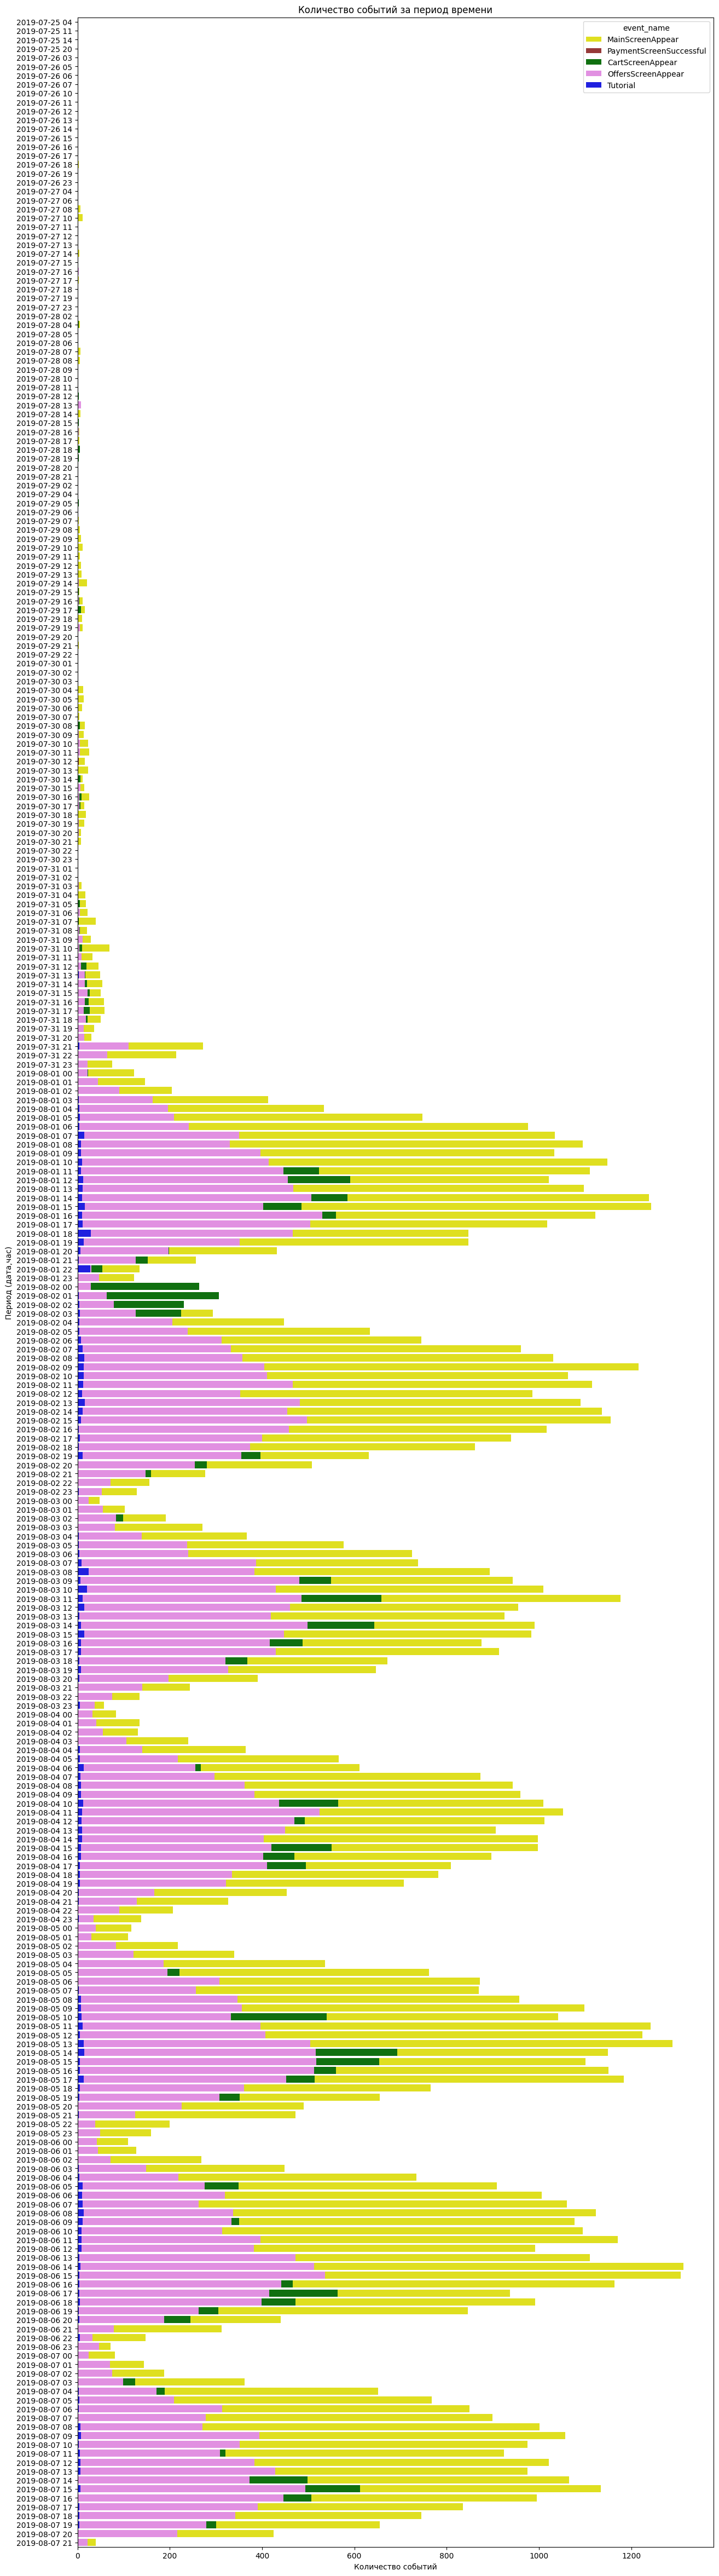

In [ ]:
#для проверки актуального периода данных в датасете построим диаграмму

plt.figure(figsize=(15, 60))

cols = ['yellow','brown', 'green', 'violet', 'blue']

cnt_event = sns.countplot(y=logs['event_dt'].dt.strftime('%Y-%m-%d %H'), hue='event_name', saturation=0.75, palette= cols, data=logs, dodge=False)

cnt_event.set_title('Количество событий за период времени')

cnt_event.set_ylabel('Период (дата,час)')

cnt_event.set_xlabel('Количество событий')

plt.show()

**Исходя из диаграммы можно утверждать что значимое для исследования количество событий начинается с периода 2019-07-31 21:00 и данные до этого периода можно удалить из анализа**

**Для того чтобы оставить в датафрейме только актуальные данные используем срез**

In [ ]:
new_logs = logs.query('event_dt > "2019-07-31 21:00"')

new_logs['event_dt'].sort_values()

new_logs

,event_name,user_id,event_dt,group,date_only
1989,MainScreenAppear,7701922487875823903,2019-07-31 21:00:57,247,2019-07-31
1990,MainScreenAppear,2539077412200498909,2019-07-31 21:01:45,247,2019-07-31
1991,OffersScreenAppear,3286987355161301427,2019-07-31 21:02:21,248,2019-07-31
1992,OffersScreenAppear,3187166762535343300,2019-07-31 21:02:23,247,2019-07-31
1993,MainScreenAppear,1118952406011435924,2019-07-31 21:03:25,248,2019-07-31
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


**С этого момента в исследование будет использоваться только датафрейм new_logs с актуальным периодом времени**

In [ ]:
#находим новую минимальную дату

new_min_date = new_logs['event_dt'].min()

new_min_date

Timestamp('2019-07-31 21:00:57')

**2019-07-31 21:00:57 - новая точка в отрезке времени исследования**

In [ ]:
#считаем обновленное число событий

new_event_sum = new_logs['event_name'].count()

new_event_sum

241724

In [ ]:
#считаем количество событий которые не вошли в актуальный период

event_difference = event_sum - new_event_sum

event_difference

1989

In [ ]:
perc_event_drop = round(event_difference/event_sum * 100, 2)

perc_event_drop

0.82

**Потеря 1989 событий из 243 тысяч или 0,82% (менее процента) - не критичная потеря**

In [ ]:
#считаем количество уникальных пользователей за актуальный период

new_user_cnt = new_logs['user_id'].nunique()

In [ ]:
#считаем количество уникальных пользователей которые не вошли в актуальный период

user_difference = user_cnt-new_user_cnt

user_difference

13

In [ ]:
perc_user_drop = round(user_difference/user_cnt * 100, 2)

perc_user_drop

0.17

**Так же как и 13 юзеров или 0,17%(менее 1%) от общего количества из 7 тысяч пользователей**

**Найдём новое значение количества событий на пользователя**

In [ ]:
new_median_event = new_logs.groupby('user_id')['event_name'].count()

new_median_event.describe()

count    7538.000000
mean       32.067392
std        65.161568
min         1.000000
25%         9.000000
50%        19.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

**Событий на пользователя стало на одно меньше -теперь их 19. Теперь с помощью графика проверим наличие всех трёх экспериментальных групп в каждом из часовых периодов для корректности дальнейшего исследования**

**Проверим с помощью графика наличие всех трёх экспериментальных групп в каждом из периодов**

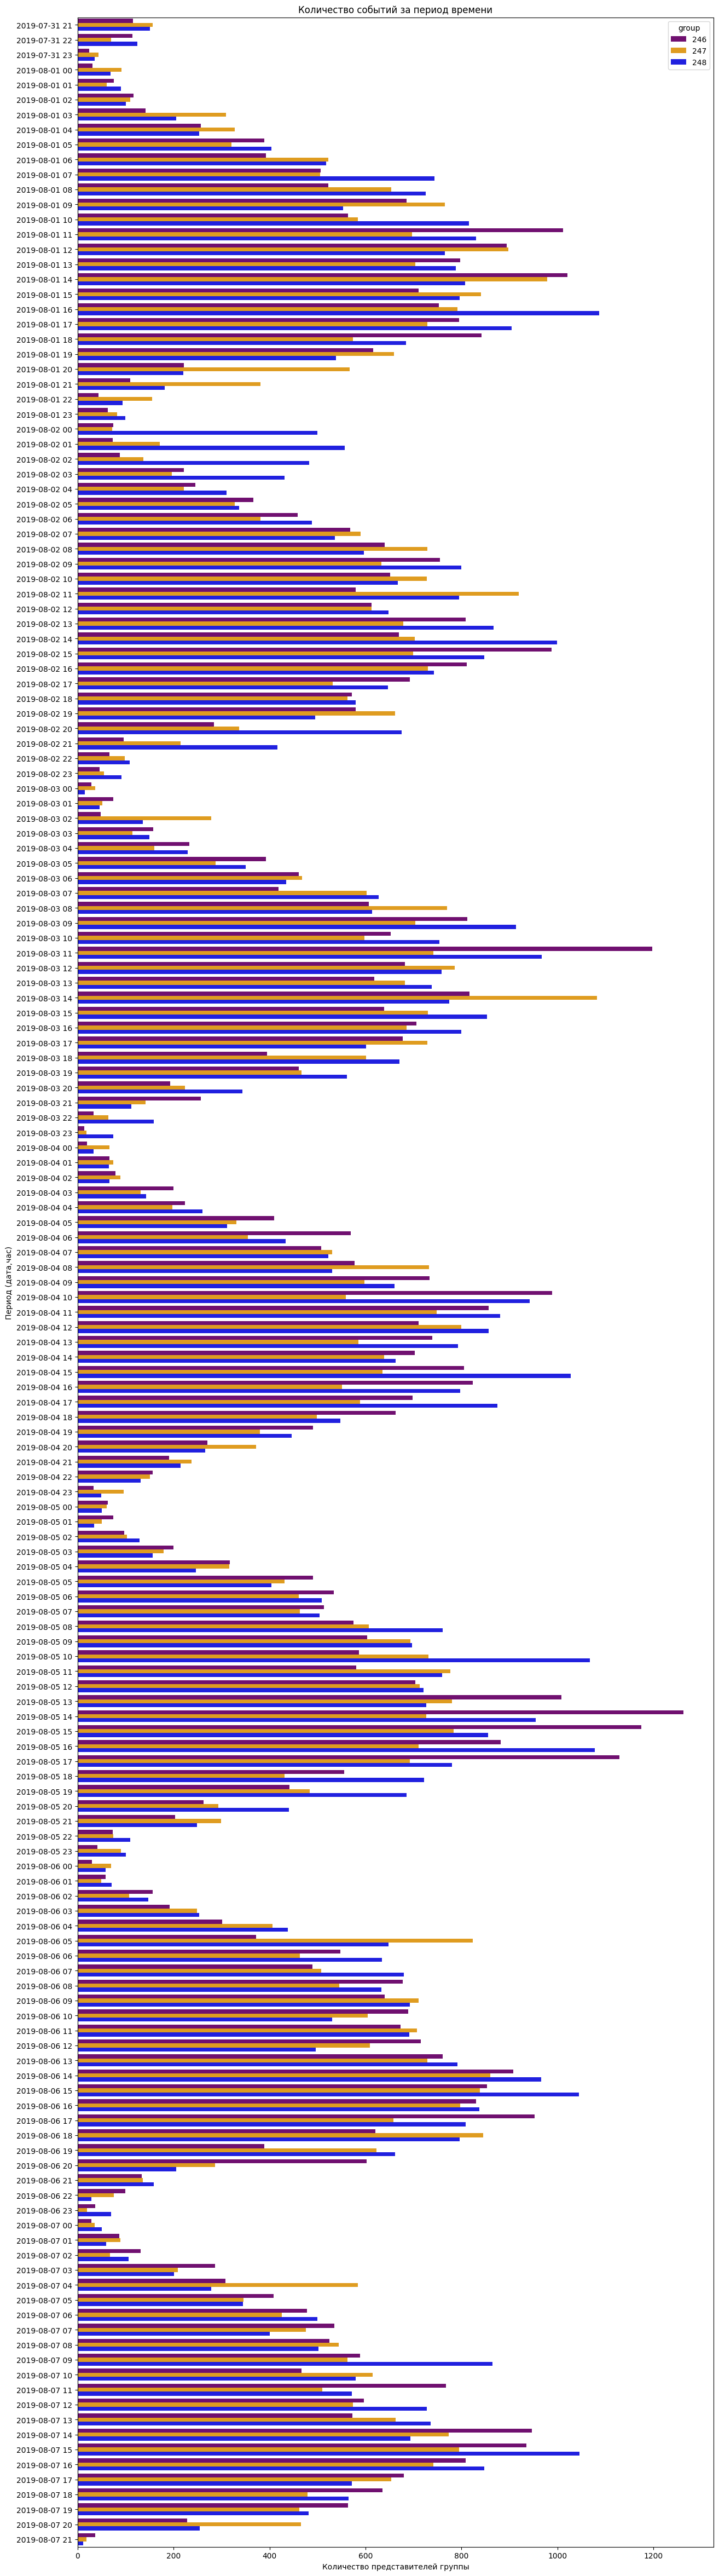

In [ ]:
plt.figure(figsize=(15, 60))

cols = ['purple','orange', 'blue']

cnt_event = sns.countplot(y=new_logs['event_dt'].dt.strftime('%Y-%m-%d %H'), hue='group', saturation=0.75, palette= cols, data=new_logs)

cnt_event.set_title('Количество событий за период времени')

cnt_event.set_ylabel('Период (дата,час)')

cnt_event.set_xlabel('Количество представителей группы')

plt.show()

## Итоги исследовательского анализа

**Определено количество событий и пользователей за актуальный период исследования, среднее количество событий на пользователя за имеющийся период и присутствие всех экпериментальных групп в актуальном периоде**

# Часть 4
# Изучение воронки событий

**C помощью графика отобразим с какой частотой возникают события**

Text(0.5, 0, 'Событие')

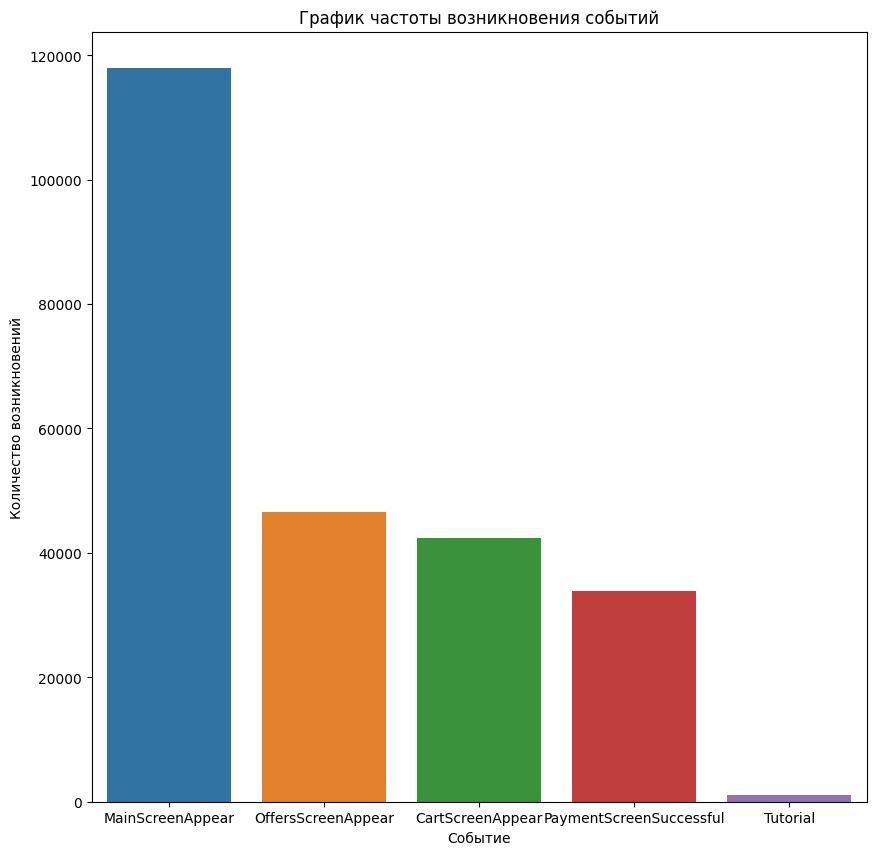

In [ ]:
freq_event = new_logs.pivot_table(index=['event_name'], values='user_id', aggfunc = 'count')\
.sort_values(by='user_id', ascending=False)

freq_event['event_name'] = freq_event.index

plt.figure(figsize=(10,10))

sns.barplot (x='event_name', y='user_id', data = freq_event)

plt.title('График частоты возникновения событий')

plt.ylabel('Количество возникновений')

plt.xlabel('Событие')

**По графику видно что просмотр главной страницы самое популярное событие в логах просмотр главной страницы, следом идёт просмотр предложений, просмотр корзины, оплата и руководство пользователя - всё логично и сходится с реальностью.**

**Малое число просмотров руководства пользователя необходимо малому числу пользователей - это говорит о том что пользователи сами могут разобраться в процессе покупки, а значит её алгоритм понятен пользователям.**

**Предполагаемая воронка событий будет строится по тому же принципу (по убыванию значений предыдущего графика). Как и говорилось ранее, туториал нужен не всем пользователям и выпадает из строения воронки, поэтому это событие можно исключить из анализа**

In [ ]:
#исключим событие туториала из данных

logs_without_tut = new_logs.query('event_name != "Tutorial"')

logs_without_tut['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'CartScreenAppear'], dtype=object)

In [ ]:
logs_without_tut

,event_name,user_id,event_dt,group,date_only
1989,MainScreenAppear,7701922487875823903,2019-07-31 21:00:57,247,2019-07-31
1990,MainScreenAppear,2539077412200498909,2019-07-31 21:01:45,247,2019-07-31
1991,OffersScreenAppear,3286987355161301427,2019-07-31 21:02:21,248,2019-07-31
1992,OffersScreenAppear,3187166762535343300,2019-07-31 21:02:23,247,2019-07-31
1993,MainScreenAppear,1118952406011435924,2019-07-31 21:03:25,248,2019-07-31
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


**Создадим таблицу с количеством уникальных пользователей на событие**

In [ ]:
fun_way = logs_without_tut.pivot_table(index=['event_name'], values='user_id', aggfunc = 'nunique')\
.sort_values(by='user_id', ascending=False).reset_index()

fun_way.columns =['event_name', 'user_cnt']

fun_way

,event_name,user_cnt
0,MainScreenAppear,7423
1,OffersScreenAppear,4597
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540


In [ ]:
# добавляем в таблицу процент от изначального количества пользователей в событии

fun_way['ratio'] = round(fun_way['user_cnt']/ new_user_cnt, 2) * 100

fun_way

,event_name,user_cnt,ratio
0,MainScreenAppear,7423,98.0
1,OffersScreenAppear,4597,61.0
2,CartScreenAppear,3736,50.0
3,PaymentScreenSuccessful,3540,47.0


**Построим воронку в абсолютных и относительных величинах**

In [ ]:
fig = px.funnel(fun_way, x='user_cnt', y='event_name', color="ratio",\
                title='Воронка процента пользователей на каждое из событий',
                labels={"event_name": "Событие", "user_cnt":"Процент(%) пользователей"}
                )

fig.show()

**По воронке наблюдается снижение процента от просмотра главного экрана к моменту оплаты. 98% пользователей просматривает главный экран (можно было бы предположить что их должно быть 100%). А до оплаты доходит только 47% пользователей. Для определения  возможных причин такого процента доходящих до оплаты пользователей необходимо проверить конверсию от шага к шагу**

In [ ]:
#добавляем в таблицу процент пользователей перешедших на следующий шаг воронки

fun_way['percentage'] = round(fun_way['user_cnt']/fun_way['user_cnt']\
.shift(periods=1, fill_value=fun_way['user_cnt'][0]/1),2) * 100

fun_way

,event_name,user_cnt,ratio,percentage
0,MainScreenAppear,7423,98.0,100.0
1,OffersScreenAppear,4597,61.0,62.0
2,CartScreenAppear,3736,50.0,81.0
3,PaymentScreenSuccessful,3540,47.0,95.0


In [ ]:
fig = px.funnel(fun_way, x= 'percentage', y='event_name', color="percentage",
                title='Воронка конверсии пользователей от события к событию',
                labels={"event_name": "Событие", "percentage":"Конверсия в следующий шаг(%)"}
                )

fig.show()

## Итоги исследования воронки событий

**Приложение имеет менее 50% пользователей которые доходят до оплаты. Причина кроется в потере пользователей при переходе с главной страницы на страницу с предложениями 38 % , при том что конверсия в страницу оплаты из корзины составляет 95%**

#Часть 5

# Изучение результатов эксперимента

**Создадим таблицу в которой будет отбражено количество пользователей в группе теста и на каждом из шагов**

In [ ]:
groups_by_events = (new_logs
                    .pivot_table(index='group', columns = 'event_name', values = 'user_id', aggfunc='nunique')
                    .rename_axis(None, axis =1)
                    .drop(columns='Tutorial')
                   )
groups_by_events['total'] = new_logs.groupby('group')['user_id'].nunique()

#создаём объединённую группу для 246 и 247

groups_by_events.loc[249]=groups_by_events.loc[246]+groups_by_events.loc[247]

groups_by_events['ratio'] = round(groups_by_events['MainScreenAppear']/groups_by_events['total'], 2)

groups_by_events

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,total,ratio
group,,,,,,
246,1266,2450,1542,1200,2484,0.99
247,1239,2479,1524,1158,2517,0.98
248,1231,2494,1531,1182,2537,0.98
249,2505,4929,3066,2358,5001,0.99


**Таблица показывает изначальную численность групп эксперимента. Изначально для A/A/B теста пользователи были разбиты на три группы 246 и 247 - контрольные с вариантами старых шрифтов и 248 - экпериментальная с новым видом шрифта. Самое популярное событие среди пользователей групп - просмотр главной страницы - его среди групп совершают 98-99% пользователей**

In [ ]:
event_names = (groups_by_events
               .sort_values(axis=1, by=246, ascending=False)
               .columns[1:5]
               .tolist()
              )
event_names

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

**Для проверки гипотезы о равенстве долей, напишем функцию:**

In [ ]:
def z_test(event_names, exp_id_1, exp_id_2, alpha_value):

    for event in event_names:

        shidak_alpha = 1 - (1 - alpha_value)**(1/16)

        successes = np.array([groups_by_events[event][exp_id_1], groups_by_events[event][exp_id_2]])
        trials = np.array([groups_by_events['total'][exp_id_1], groups_by_events['total'][exp_id_2]])

        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        difference = p1 - p2
        z_value = difference/mth.sqrt(p_combined * (1-p_combined) * (1/trials[0] + 1/trials[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print()

        print('p-значение:', p_value)

        if p_value < shidak_alpha:
            print('Отвергаем нулевую гипотезу:между долями групп {} и {} по событию {} есть значимая разница'
            .format(exp_id_1, exp_id_2, event)
                 )
        else:
            print(
                 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп {} и {} разными'
                 .format(exp_id_1, exp_id_2, event)
                 )

**Для проверки гипотез выберем уровень значимости 0.05, так как при выборе уровня значимости 0.01 каждый десятый раз можно получать ложный результат ,чтобы повысить мощность теста, сохраняя FWER < ɑ, применили в функции метод Шидака, а не метод Бонфферони. Будем проверять группы 246 и 247 в A/A тесте, шрифты между собой и объединённую группу старых шрифтов и экспериментальную группу 248**

**Необходимо проверить гипотезы**

**Н_0:Доли уникальных посетителей, побывавших на этапе воронки из групп 246 и 247 равны**

**Н_1:Доли уникальных посетителей, побывавших на этапе воронки из групп 246 и 247  не равны**

In [ ]:
z_test(event_names, 246, 247, 0.05)


p-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 247 разными

p-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 247 разными

p-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 247 разными

p-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 247 разными


**A/A тест не показал значимой разницы - обе группы со страными шрифтами считаем контрольными, не обнаружены факторы, которые могли бы привести к искажению результатов. Проверим что покажут сравнения контрольных групп с экпериментальной**

**Н_0:Доли уникальных посетителей, побывавших на этапе воронки из групп 246 и 248 равны**

**Н_1:Доли уникальных посетителей, побывавших на этапе воронки из групп 246 и 248  не равны***

In [ ]:
z_test(event_names, 246, 248, 0.05)


p-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными

p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными

p-значение: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными

p-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 разными


**Значимых различий между группами не выявлено. Доли групп равны.**

**Н_0:Доли уникальных посетителей, побывавших на этапе воронки из групп 247 и 248 равны**

**Н_1:Доли уникальных посетителей, побывавших на этапе воронки из групп 247 и 248  не равны***

In [ ]:
z_test(event_names, 247, 248, 0.05)


p-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными

p-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными

p-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными

p-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 разными


**Значимых различий между группами не выявлено. Доли групп равны.**

**Н_0:Доли уникальных посетителей, побывавших на этапе воронки из групп объединённых 246,247 и 248 равны**

**Н_1:Доли уникальных посетителей, побывавших на этапе воронки из групп объединённых 246,247 и 248 не равны**

In [ ]:
z_test(event_names, 249, 248, 0.05)


p-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 249 и 248 разными

p-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 249 и 248 разными

p-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 249 и 248 разными

p-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 249 и 248 разными


**Значимых различий между группами не выявлено, объединённая группа аналогично не продемострировала отличия от экспериментальной. Доли групп равны.**

## Итоги изучения результатов эксперимента

**Статистические методы не показали явного различия между группами при использовании разного вида шрифтов. Во всех 16 экспериментах не получилось опровергнуть нулевую гипотезу о равенстве проверяемых групп**

# Итоговые выводы исследования

**Нашими усилиями было проделано исследование с целью найти провести анализ данных таблицы логов при помощи которых стартап сможет организовать стратегию работы с пользователями и принять решение о необходимости внедрения новых шрифтов в приложении.**

**Рекомендации по дальнейшей стратегии работы с пользователями и нововведениям в виде шрифтов:**

**1.Среди пользователей приложения только 47% пользователей доходит до оплаты. Больше всего пользователей приложение теряет на шаге перехода от главной страницы на страницу с прделожениями. Можно предлоложить что первоначальная страница оталкивает пользователя от продолжения дальнейшего ознакомления с предложениями и дальнейшим содержанием приложения. Необходимо изучить её, придумать новую версию и провести исследование со старой и новой версией страницы. При переходе от предложений к корзине теряется ещё 12% пользователей. Это повод проверить и переход от предложений к корзине. Конверсия перехода к оплате из корзины составляет 95% это достаточный результат чтобы полагать что с переходом к оплате товара покупатель не испытывает больших сложностей.**

**2.Проведённые 16 проверок статистических гипотез не выявили значимых различий между исследуемыми группами пользователей - это означает что страхи менеджеров не подтвердились и пользователи экспериментальной группы продолжили пользоваться приложением как и раньше.**

**3.Новые шрифты, возможно, не вызвали ожидаемого дизайнерами эффекта. По крайней мере в активности старых пользователей. Возможно, новый дизайн шрифта может повлиять на показатели новых пользователей(конверсию и т.д.) или на другие показатели старых пользователей(ROI,Retention Rate). Это повод провести новое исследование с прошествием времени, в случае принятия варианта нового шрифта для приложения.**